In [ ]:
!pip install split-folders matplotlib opencv-python spicy

In [ ]:
import numpy as np
import cv2 as cv
import os
import splitfolders
import matplotlib.pyplot as plt
import zipfile #Intégrer fichier zip du drive

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

## Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
zip_train = zipfile.ZipFile('/content/drive/MyDrive/data.zip', 'r')
zip_train.extractall('/tmp')
zip_train.close()

In [ ]:
# split data in a new folder named data-split 70% 20% 10%
splitfolders.ratio("/tmp/data", output="data-split", seed=1337, ratio=(0.7, 0.2, 0.1), group_prefix=None, move=False)

Copying files: 52000 files [00:10, 5057.91 files/s]


In [ ]:
datagen = ImageDataGenerator()

In [ ]:
# define classes name
class_names = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

In [ ]:
# training data
train_generator = datagen.flow_from_directory(
    directory="data-split/train/",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

Found 36505 images belonging to 26 classes.


In [ ]:
# validation data
valid_generator = datagen.flow_from_directory(
    directory="data-split/val/",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

Found 10485 images belonging to 26 classes.


In [ ]:
# test data
test_generator = datagen.flow_from_directory(
    directory="data-split/test/",
    classes = class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

Found 5247 images belonging to 26 classes.


## Model

In [ ]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

In [ ]:
# build the entire model
x = layers.BatchNormalization()(resnet_50.output) # Normaliser
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(26, activation='softmax')(x) # nb de classes
model = Model(inputs = resnet_50.input, outputs = predictions)

## Train

In [ ]:
# define training function
def trainModel(model, epochs, optimizer):
    batch_size = 96 # test avec 32, 64...
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator, validation_data=valid_generator, epochs=epochs, batch_size=batch_size)

In [ ]:
# launch the training
model_history = trainModel(model = model, epochs = 20, optimizer = "Adam") # 10 epoch de base, test a 15, 20...

Epoch 1/20
1141/1141 [==============================] - 166s 141ms/step - loss: 2.3686 - accuracy: 0.2613 - val_loss: 1.0666 - val_accuracy: 0.6627
Epoch 2/20
1141/1141 [==============================] - 160s 140ms/step - loss: 1.3559 - accuracy: 0.5385 - val_loss: 0.7093 - val_accuracy: 0.7433
Epoch 3/20
1141/1141 [==============================] - 159s 140ms/step - loss: 1.0421 - accuracy: 0.6607 - val_loss: 0.5638 - val_accuracy: 0.8203
Epoch 4/20
1141/1141 [==============================] - 160s 140ms/step - loss: 0.8852 - accuracy: 0.7226 - val_loss: 0.4447 - val_accuracy: 0.8739
Epoch 5/20
1141/1141 [==============================] - 159s 140ms/step - loss: 0.7713 - accuracy: 0.7687 - val_loss: 0.3733 - val_accuracy: 0.8946
Epoch 6/20
1141/1141 [==============================] - 160s 140ms/step - loss: 0.6836 - accuracy: 0.8019 - val_loss: 0.3370 - val_accuracy: 0.9074
Epoch 7/20
1141/1141 [==============================] - 167s 146ms/step - loss: 0.6297 - accuracy: 0.8233 - val_

### Loss curves

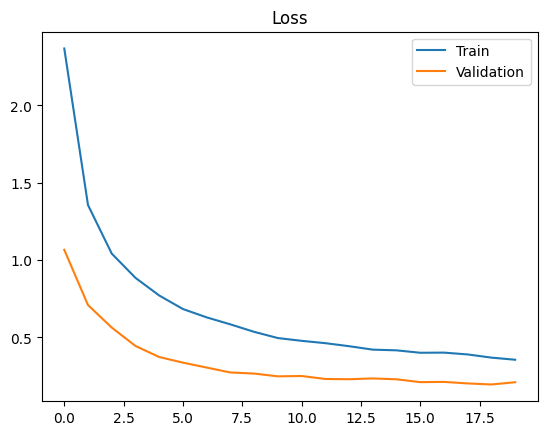

In [ ]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

### Accuracy curves

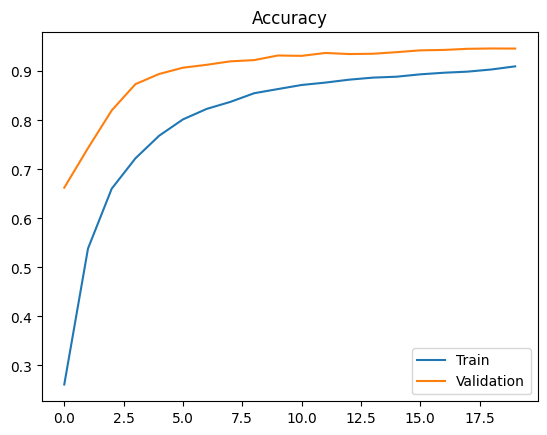

In [ ]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

## Evaluate

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test loss: ", test_loss)
print("Best accuracy: ", test_acc*100)

164/164 [==============================] - 19s 114ms/step - loss: 0.2006 - accuracy: 0.9512
Test loss:  0.20056554675102234
Best accuracy:  95.12102007865906


## Test the model with new image

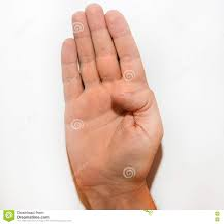

In [ ]:
img = tf.keras.preprocessing.image.load_img('B4.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array])
# Prétraiter l'image (normalisation)
img_array = preprocess_input(img_array)
img

In [ ]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)

1/1 [==============================] - 0s 26ms/step
[[1.7277344e-01 4.7887513e-01 1.8529910e-04 1.3093859e-03 2.6857656e-01
  9.4125327e-03 5.4009649e-04 1.0743411e-03 2.0448877e-02 3.0148705e-04
  4.9539781e-03 3.1064579e-04 3.3195582e-03 2.2415396e-04 1.0690779e-04
  5.6655217e-06 7.9434998e-05 4.3532164e-03 2.2531496e-03 1.9416854e-03
  1.3269808e-02 1.1624746e-03 7.9702344e-03 3.8925591e-03 2.3060229e-03
  3.5327114e-04]]


In [ ]:
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

[1]


In [ ]:
# transform classes number into classes name
class_names[class_id.item()]

'B'

## Save Model

In [ ]:
model.save('test_model.h5')
model.save('model_saved')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model('model_saved')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

## Télécharger les documents depuis Colab

In [ ]:
from google.colab import files
import shutil

In [ ]:
# Créer une archive zip de plusieurs fichiers ou d'un dossier
shutil.make_archive('model_saved', 'zip', 'model_saved')

# Téléchargement de l'archive zip
files.download('model_saved.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('test_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>